# Baseline Implementation of Object Recognition System
## By: Blake Barber
#### Blake.Barber@usu.edu

This program implements the methodology introduced in the paper, "An efficient technique for object recognition using Shi-Tomasi corner
detection algorithm" by Monika Bansal, Munish Kumar, Manish Kumar, and Krishan Kumar.

## Step 1: Data preparation

Data was downloaded from: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip

The data was then extracted and placed in a folder titled "caltech101" in the root of the workspace.

The following code loads the data and removes an unnecessary folder called "BACKGROUND_Google" that we dont want to include in the 101 catagories.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# Define dataset directory
dataset_dir = "caltech101/101_ObjectCategories"

# Safely remove "BACKGROUND_Google" folder if it exists
background_folder = os.path.join(dataset_dir, "BACKGROUND_Google")
if os.path.exists(background_folder):
    try:
        # Remove the folder
        for root, dirs, files in os.walk(background_folder, topdown=False):
            for file in files:
                os.remove(os.path.join(root, file))
            for dir in dirs:
                os.rmdir(os.path.join(root, dir))
        os.rmdir(background_folder)
        print(f"Removed folder: {background_folder}")
    except Exception as e:
        print(f"Error while removing {background_folder}: {e}")
else:
    print(f"No {background_folder} folder to remove.")

# Filter out non-directory entries
classes = sorted([category for category in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, category))])

# Initialize variables
image_data = []
labels = []

# Use the filtered `classes` list for loading images
for label, category in enumerate(classes):
    category_path = os.path.join(dataset_dir, category)
    for file in os.listdir(category_path):
        img_path = os.path.join(category_path, file)
        if os.path.isfile(img_path):  # Ensure it's a valid file, not a subdirectory
            img = cv2.imread(img_path)
            if img is not None:  # Ensure the image is valid
                img_resized = cv2.resize(img, (128, 128))
                image_data.append(img_resized)
                labels.append(label)

# Convert to numpy arrays
image_data = np.array(image_data, dtype=np.float32) / 255.0
labels = np.array(labels, dtype=np.int32)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_data, labels, test_size=0.2, stratify=labels, random_state=42
)

print(f"Classes: {classes}")
print(f"Total Valid Classes: {len(classes)}")
print(f"Training Data: {X_train.shape}, Testing Data: {X_test.shape}")

No caltech101/101_ObjectCategories/BACKGROUND_Google folder to remove.
Classes: ['Faces', 'Faces_easy', 'Leopards', 'Motorbikes', 'accordion', 'airplanes', 'anchor', 'ant', 'barrel', 'bass', 'beaver', 'binocular', 'bonsai', 'brain', 'brontosaurus', 'buddha', 'butterfly', 'camera', 'cannon', 'car_side', 'ceiling_fan', 'cellphone', 'chair', 'chandelier', 'cougar_body', 'cougar_face', 'crab', 'crayfish', 'crocodile', 'crocodile_head', 'cup', 'dalmatian', 'dollar_bill', 'dolphin', 'dragonfly', 'electric_guitar', 'elephant', 'emu', 'euphonium', 'ewer', 'ferry', 'flamingo', 'flamingo_head', 'garfield', 'gerenuk', 'gramophone', 'grand_piano', 'hawksbill', 'headphone', 'hedgehog', 'helicopter', 'ibis', 'inline_skate', 'joshua_tree', 'kangaroo', 'ketch', 'lamp', 'laptop', 'llama', 'lobster', 'lotus', 'mandolin', 'mayfly', 'menorah', 'metronome', 'minaret', 'nautilus', 'octopus', 'okapi', 'pagoda', 'panda', 'pigeon', 'pizza', 'platypus', 'pyramid', 'revolver', 'rhino', 'rooster', 'saxophone', 's

## Visualize Samples

This next code part visualizes some samples of the data to ensure that we have correctly loaded the files and helps verify we are ready to start feature extraciton.

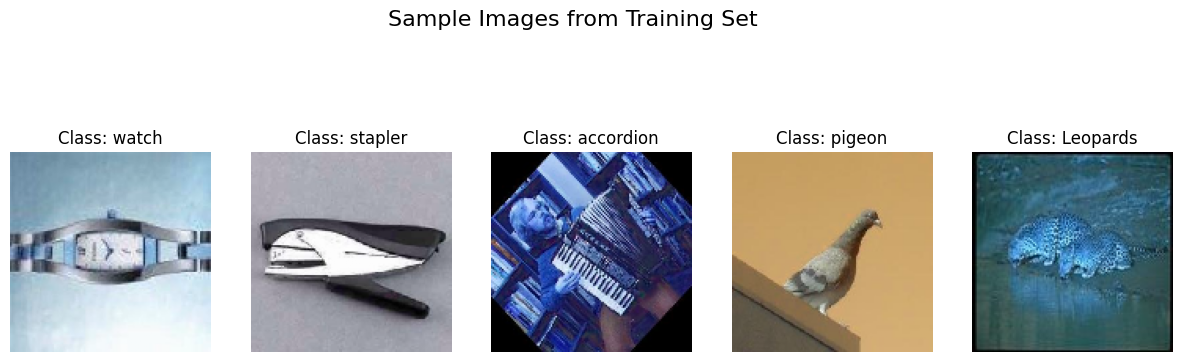

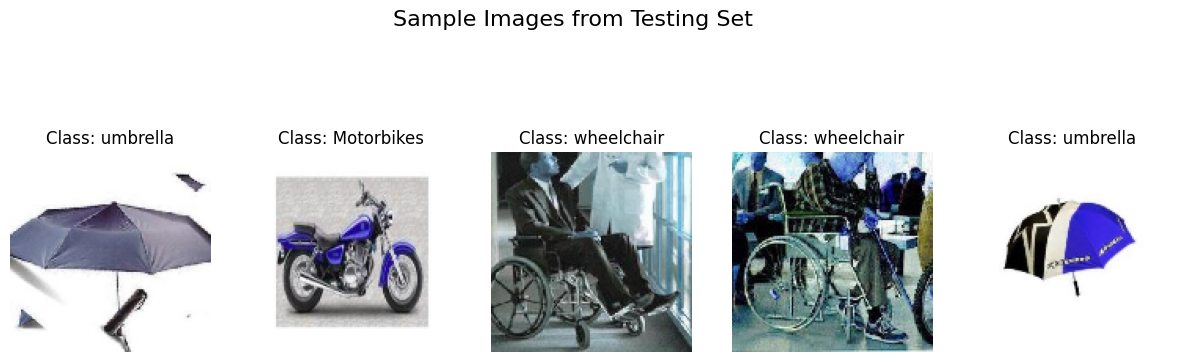

In [2]:
import matplotlib.pyplot as plt

# Function to plot images with labels
def plot_samples(images, labels, classes, num_samples=5, dataset_name="Dataset"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))  # Randomly pick an index
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[idx])
        plt.title(f"Class: {classes[labels[idx]]}")
        plt.axis("off")
    plt.suptitle(f"Sample Images from {dataset_name}", fontsize=16)
    plt.show()

# Visualize training samples
plot_samples(X_train, y_train, classes, num_samples=5, dataset_name="Training Set")

# Visualize testing samples
plot_samples(X_test, y_test, classes, num_samples=5, dataset_name="Testing Set")


# Pipeline 1: Shi-Tomasi Corner Detection


## Step 1. Import the needed libraries

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


## Step 2: Shi-Tomasi Corner Detection

Shi-Tomasi is used to detect strong corners in the image, which are then used as key points for further processing. This function extract the corners for one image

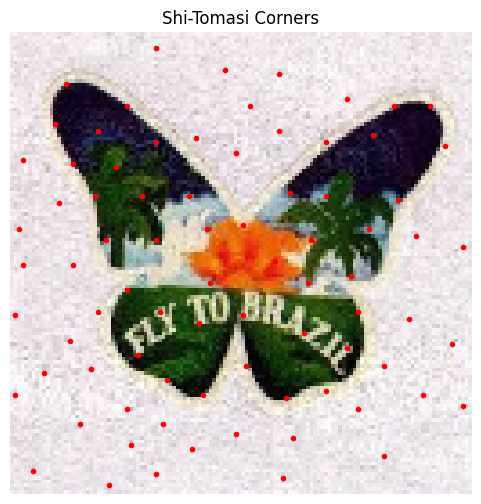

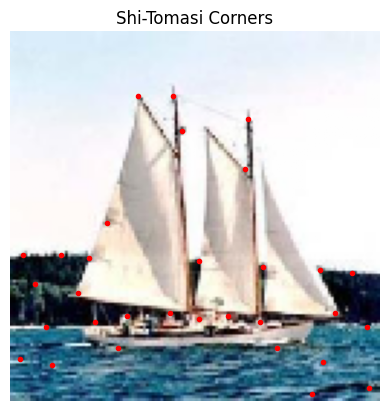

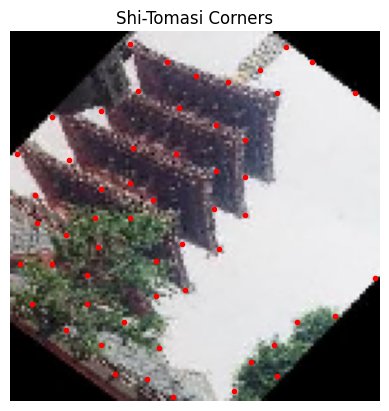

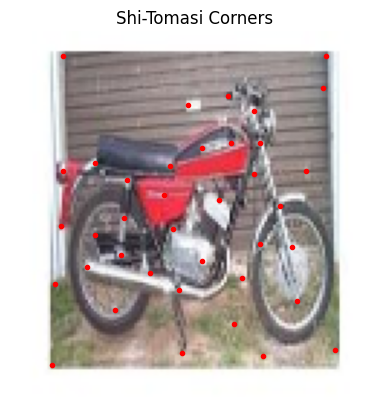

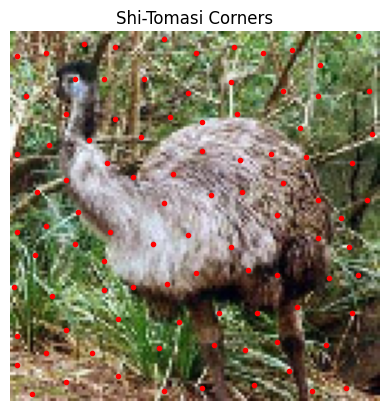

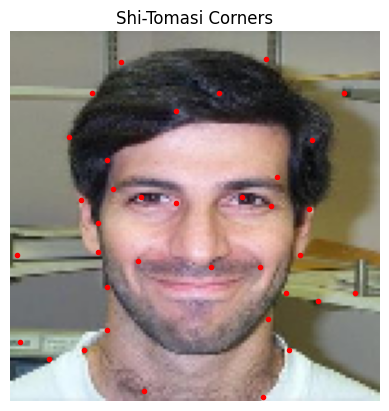

In [4]:
def extract_shi_tomasi_features(image, max_corners=100, quality_level=0.01, min_distance=10):
    """
    Extract Shi-Tomasi corners from the image.
    
    Parameters:
    - image: Input image.
    - max_corners: Maximum number of corners to detect.
    - quality_level: Minimum accepted quality of corners.
    - min_distance: Minimum distance between corners.
    
    Returns:
    - corners: Array of detected corners.
    """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    corners = cv2.goodFeaturesToTrack(gray, maxCorners=max_corners, qualityLevel=quality_level, minDistance=min_distance)
    corners = np.astype(corners, int)
    return corners

# Example usage using random image from the training set
random_idx = np.random.randint(0, len(X_train))
sample_image = X_train[random_idx]  # Use the first image from the training set
shi_tomasi_corners = extract_shi_tomasi_features(sample_image)

# Visualize Shi-Tomasi corners
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
if shi_tomasi_corners is not None:
    for corner in shi_tomasi_corners:
        x, y = corner.ravel()
        plt.plot(x, y, 'ro', markersize=3)
plt.title("Shi-Tomasi Corners")
plt.axis("off")
plt.show()

for i in range(5):  # Show corners for 5 random images
    img = X_train[np.random.randint(0, len(X_train))]
    corners = extract_shi_tomasi_features(img, max_corners=200, quality_level=0.08, min_distance=10)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if corners is not None:
        for corner in corners:
            x, y = corner.ravel()
            plt.plot(x, y, 'ro', markersize=3)
    plt.title("Shi-Tomasi Corners")
    plt.axis("off")
    plt.show()



## Step 3: Feature Normalization

Normalize the extracted Shi-Tomasi corner features for consistency across the dataset.

In [5]:
def normalize_features(corners, image_shape):
    if corners is None or len(corners) == 0:
        return np.zeros((1, 2))  # Return dummy value for consistency
    height, width = image_shape[:2]
    normalized_corners = corners.reshape(-1, 2) / np.array([width, height])
    return normalized_corners





# Example usage
normalized_corners = normalize_features(shi_tomasi_corners, sample_image.shape)
print(f"Normalized Corners:\n{normalized_corners}")


Normalized Corners:
[[0.2734375 0.6953125]
 [0.3125    0.4453125]
 [0.40625   0.625    ]
 [0.3203125 0.6015625]
 [0.7265625 0.6796875]
 [0.6328125 0.6484375]
 [0.734375  0.5234375]
 [0.203125  0.4453125]
 [0.5       0.609375 ]
 [0.3828125 0.3515625]
 [0.8359375 0.359375 ]
 [0.6796875 0.3515625]
 [0.640625  0.5390625]
 [0.6015625 0.34375  ]
 [0.6484375 0.4453125]
 [0.7734375 0.421875 ]
 [0.90625   0.15625  ]
 [0.4140625 0.78125  ]
 [0.25      0.5546875]
 [0.421875  0.421875 ]
 [0.4296875 0.5390625]
 [0.5       0.4140625]
 [0.1171875 0.109375 ]
 [0.59375   0.7890625]
 [0.6796875 0.234375 ]
 [0.5078125 0.71875  ]
 [0.3125    0.234375 ]
 [0.828125  0.15625  ]
 [0.2265625 0.2890625]
 [0.0078125 0.78125  ]
 [0.28125   0.3515625]
 [0.75      0.6015625]
 [0.9375    0.2421875]
 [0.5703125 0.4921875]
 [0.1328125 0.28125  ]
 [0.6796875 0.7734375]
 [0.3359375 0.75     ]
 [0.125     0.6640625]
 [0.8046875 0.71875  ]
 [0.484375  0.2578125]
 [0.1796875 0.3515625]
 [0.09375   0.1953125]
 [0.25      0.

## Step 4. Extract Features for the Dataset

This step processes the entire dataset to extract normalized features and ensures that each feature vector has a consistent length (using truncation or padding).

In [6]:
def extract_features_for_dataset(images, max_corners=100, quality_level=0.01, min_distance=10):
    """
    Extract and normalize Shi-Tomasi features for a dataset, ensuring consistent dimensions.

    Parameters:
    - images: List of input images.
    - max_corners: Maximum number of corners to retain (truncate or pad).
    - quality_level: Minimum accepted quality of corners.
    - min_distance: Minimum distance between corners.

    Returns:
    - features: A 2D numpy array with consistent dimensions.
    """
    features = []
    for img in images:
        corners = extract_shi_tomasi_features(img, max_corners=max_corners, quality_level=quality_level, min_distance=min_distance)
        normalized = normalize_features(corners, img.shape)
        # Flatten and truncate/pad to ensure consistent dimensions
        flattened = normalized.flatten()
        if len(flattened) > max_corners * 2:
            flattened = flattened[:max_corners * 2]  # Truncate
        else:
            flattened = np.pad(flattened, (0, max_corners * 2 - len(flattened)))  # Pad with zeros
        features.append(flattened)
    return np.array(features)


## Step 5: Define LPP for Dimensionality Reduction 
Apply Locality Preserving Projection (LPP) to reduce the feature dimensions while preserving locality.

In [7]:
import numpy as np
from scipy.sparse import csgraph
from scipy.linalg import eigh

def apply_lpp(features, n_components=50, n_neighbors=5, t=1.0, reg=1e-5):
    """
    Apply Locality Preserving Projection (LPP).

    Parameters:
    - features: 2D numpy array of shape (n_samples, n_features).
    - n_components: Number of dimensions to reduce to.
    - n_neighbors: Number of nearest neighbors for graph construction.
    - t: Parameter for heat kernel in weight computation.
    - reg: Regularization parameter to ensure numerical stability.

    Returns:
    - reduced_features: Features reduced to n_components dimensions.
    """
    # Number of samples
    n_samples = features.shape[0]

    # Step 1: Construct the Weight Matrix W
    from sklearn.neighbors import NearestNeighbors

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='auto').fit(features)
    distances, indices = nbrs.kneighbors(features)

    W = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for idx in indices[i]:
            if idx != i:
                # Heat Kernel Weight
                W[i, idx] = np.exp(-np.linalg.norm(features[i] - features[idx])**2 / t)
                W[idx, i] = W[i, idx]  # Ensure symmetry

    # Step 2: Compute the Diagonal Degree Matrix D and Laplacian Matrix L
    D = np.diag(W.sum(axis=1))
    L = D - W

    # Step 3: Compute X^T L X and X^T D X
    X = features
    XTLX = X.T @ L @ X
    XTDX = X.T @ D @ X

    # Regularization to avoid singularity
    XTDX += reg * np.eye(XTDX.shape[0])

    # Step 4: Solve the generalized eigenvalue problem
    eigvals, eigvecs = eigh(XTLX, XTDX)

    # Step 5: Sort eigenvalues and select the smallest ones
    idx = np.argsort(eigvals)
    eigvecs = eigvecs[:, idx]

    # Step 6: Select the top n_components eigenvectors
    transformation_matrix = eigvecs[:, :n_components]

    # Step 7: Transform the features
    reduced_features = X @ transformation_matrix

    return reduced_features


## Step 6. Use grid search to find best parameters

While not explicitely called out in the paper, it is implied that the authors looked for the best parameters first.

In [8]:
import json

def grid_search_shi_tomasi(X_train, y_train, param_grid, results_file="grid_search_results.json"):
    """
    Perform grid search to optimize Shi-Tomasi parameters and LPP dimensions.
    Save results incrementally and monitor progress.

    Parameters:
    - X_train: Training images.
    - y_train: Training labels.
    - param_grid: Dictionary of parameters to search.
    - results_file: File to save intermediate results.

    Returns:
    - best_params: Best parameter combination.
    - best_score: Best cross-validation score.
    """
    best_params = None
    best_score = 0
    all_results = []

    # Initialize progress tracking
    total_combinations = (
        len(param_grid['maxCorners']) *
        len(param_grid['qualityLevel']) *
        len(param_grid['minDistance']) *
        len(param_grid['n_components'])
    )
    completed_combinations = 0

    for max_corners in param_grid['maxCorners']:
        for quality_level in param_grid['qualityLevel']:
            for min_distance in param_grid['minDistance']:
                for n_components in param_grid['n_components']:
                    # Monitor progress
                    completed_combinations += 1
                    print(f"Progress: {completed_combinations}/{total_combinations} combinations tested")

                    # Extract features
                    features = extract_features_for_dataset(
                        X_train,
                        max_corners=max_corners,
                        quality_level=quality_level,
                        min_distance=min_distance
                    )

                    # Apply LPP with n_components
                    features_reduced = apply_lpp(features, n_components)

                    # Evaluate with a lightweight classifier (e.g., k-NN)
                    knn = KNeighborsClassifier(n_neighbors=3)
                    scores = cross_val_score(knn, features_reduced, y_train, cv=3, n_jobs=-1)  # 3-fold cross-validation and use all CPU cores
                    avg_score = np.mean(scores)

                    # Record the result
                    result = {
                        'maxCorners': max_corners,
                        'qualityLevel': quality_level,
                        'minDistance': min_distance,
                        'n_components': n_components,
                        'avg_score': avg_score
                    }
                    all_results.append(result)

                    # Save the result incrementally
                    with open(results_file, "w") as f:
                        json.dump(all_results, f, indent=4)

                    # Update best parameters if the score improves
                    if avg_score > best_score:
                        best_score = avg_score
                        best_params = {
                            'maxCorners': max_corners,
                            'qualityLevel': quality_level,
                            'minDistance': min_distance,
                            'n_components': n_components
                        }

    # Save best parameters and score after the entire grid search completes
    with open(results_file, "a") as f:
        f.write(f"\nBest Parameters: {best_params}\n")
        f.write(f"Best Score: {best_score}\n")

    return best_params, best_score

## Step 7: Execute Grid Search

Optimize Shi-Tomasi parameters using grid search.

In [9]:
# Define parameter grid
param_grid = {
    'maxCorners': [100, 150],
    'qualityLevel': [0.01, 0.02],
    'minDistance': [8, 10],
    'n_components': [20, 30],
}

import time
start_time = time.time()
best_params, best_score = grid_search_shi_tomasi(X_train, y_train, param_grid)
end_time = time.time()
print(f"Execution Time: {end_time - start_time:.2f} seconds")

print(f"Refined Best Parameters: {best_params}")
print(f"Refined Best Score: {best_score:.4f}")

Progress: 1/16 combinations tested
Progress: 2/16 combinations tested
Progress: 3/16 combinations tested
Progress: 4/16 combinations tested
Progress: 5/16 combinations tested
Progress: 6/16 combinations tested
Progress: 7/16 combinations tested
Progress: 8/16 combinations tested
Progress: 9/16 combinations tested
Progress: 10/16 combinations tested
Progress: 11/16 combinations tested
Progress: 12/16 combinations tested
Progress: 13/16 combinations tested
Progress: 14/16 combinations tested
Progress: 15/16 combinations tested
Progress: 16/16 combinations tested
Execution Time: 39.57 seconds
Refined Best Parameters: {'maxCorners': 100, 'qualityLevel': 0.02, 'minDistance': 8, 'n_components': 30}
Refined Best Score: 0.1013


## Step 8: Extract Features with Optimized Parameters

Use the best parameters to extract features.

In [10]:
# Extract features for training and testing datasets
X_train_features = extract_features_for_dataset(
    X_train,
    max_corners=best_params['maxCorners'],
    quality_level=best_params['qualityLevel'],
    min_distance=best_params['minDistance']
)

X_test_features = extract_features_for_dataset(
    X_test,
    max_corners=best_params['maxCorners'],
    quality_level=best_params['qualityLevel'],
    min_distance=best_params['minDistance']
)

## Step 9: Apply LPP and Train Classifier

Reduce dimensionality and evaluate performance.

In [11]:
# Apply LPP
X_train_reduced = apply_lpp(X_train_features, n_components=50, n_neighbors=5)
X_test_reduced = apply_lpp(X_test_features, n_components=50, n_neighbors=5)

# Train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_reduced, y_train)

# Evaluate k-NN classifier
y_pred_knn = knn.predict(X_test_reduced)
print("k-NN Classifier Report:")
print(classification_report(y_test, y_pred_knn, target_names=classes))

# Train Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)

# Evaluate Decision Tree classifier
y_pred_dt = dt.predict(X_test_reduced)
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt, target_names=classes))

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_reduced, y_train)

# Evaluate Random Forest classifier
y_pred_rf = rf.predict(X_test_reduced)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf, target_names=classes))


k-NN Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.07      0.23      0.11        87
     Faces_easy       0.05      0.10      0.07        87
       Leopards       0.00      0.00      0.00        40
     Motorbikes       0.08      0.12      0.10       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.16      0.29      0.21       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.04      0.04      0.04        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.10      0.11      0.11         9
         buddha       0.00      0.00      0.00        17
      

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

Decision Tree Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.03      0.01      0.02        87
     Faces_easy       0.00      0.00      0.00        87
       Leopards       0.00      0.00      0.00        40
     Motorbikes       0.16      0.02      0.03       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.06      0.06      0.06       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.00      0.00      0.00        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.00      0.00      0.00         9
         buddha       0.00      0.00      0.00        

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

Random Forest Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.06      0.25      0.10        87
     Faces_easy       0.06      0.06      0.06        87
       Leopards       0.05      0.12      0.07        40
     Motorbikes       0.05      0.03      0.03       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.06      0.24      0.10       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.00      0.00      0.00        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.00      0.00      0.00         9
         buddha       0.00      0.00      0.00        

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

In [12]:
# Apply LPP
X_train_reduced = apply_lpp(X_train_features, n_components=50)
X_test_reduced = apply_lpp(X_test_features, n_components=50)

# Train k-NN classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_reduced, y_train)

# Evaluate k-NN classifier
y_pred_knn = knn.predict(X_test_reduced)
print("k-NN Classifier Report:")
print(classification_report(y_test, y_pred_knn, target_names=classes))

# Train Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_reduced, y_train)

# Evaluate Decision Tree classifier
y_pred_dt = dt.predict(X_test_reduced)
print("Decision Tree Classifier Report:")
print(classification_report(y_test, y_pred_dt, target_names=classes))

# Train Random Forest classifier
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train_reduced, y_train)

# Evaluate Random Forest classifier
y_pred_rf = rf.predict(X_test_reduced)
print("Random Forest Classifier Report:")
print(classification_report(y_test, y_pred_rf, target_names=classes))


k-NN Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.07      0.23      0.11        87
     Faces_easy       0.05      0.10      0.07        87
       Leopards       0.00      0.00      0.00        40
     Motorbikes       0.08      0.12      0.10       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.16      0.29      0.21       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.04      0.04      0.04        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.10      0.11      0.11         9
         buddha       0.00      0.00      0.00        17
      

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

Decision Tree Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.03      0.01      0.02        87
     Faces_easy       0.00      0.00      0.00        87
       Leopards       0.00      0.00      0.00        40
     Motorbikes       0.16      0.02      0.03       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.06      0.06      0.06       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.00      0.00      0.00        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.00      0.00      0.00         9
         buddha       0.00      0.00      0.00        

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

Random Forest Classifier Report:
                 precision    recall  f1-score   support

          Faces       0.06      0.25      0.10        87
     Faces_easy       0.06      0.06      0.06        87
       Leopards       0.05      0.12      0.07        40
     Motorbikes       0.05      0.03      0.03       160
      accordion       0.00      0.00      0.00        11
      airplanes       0.06      0.24      0.10       160
         anchor       0.00      0.00      0.00         8
            ant       0.00      0.00      0.00         8
         barrel       0.00      0.00      0.00         9
           bass       0.00      0.00      0.00        11
         beaver       0.00      0.00      0.00         9
      binocular       0.00      0.00      0.00         7
         bonsai       0.00      0.00      0.00        26
          brain       0.00      0.00      0.00        20
   brontosaurus       0.00      0.00      0.00         9
         buddha       0.00      0.00      0.00        

/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/blakebarber/Desktop/Grad School/Fall 24/Computer Vision/Final Project/Final Project Code/project_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

## Compare Classifiers

In [13]:
# Calculate accuracy for each classifier
knn_accuracy = accuracy_score(y_test, y_pred_knn)
dt_accuracy = accuracy_score(y_test, y_pred_dt)
rf_accuracy = accuracy_score(y_test, y_pred_rf)

# Create a dictionary to store the results
results = {
    "Classifier": ["k-NN", "Decision Tree", "Random Forest"],
    "Accuracy": [knn_accuracy, dt_accuracy, rf_accuracy]
}

# Convert to a Pandas DataFrame
results_df = pd.DataFrame(results)

# Display the table
print("Classifier Accuracy Comparison:")
print(results_df)

from IPython.display import display
display(results_df)


Classifier Accuracy Comparison:
      Classifier  Accuracy
0           k-NN  0.061060
1  Decision Tree  0.013249
2  Random Forest  0.044355


,Classifier,Accuracy
0,k-NN,0.061060
1,Decision Tree,0.013249
2,Random Forest,0.044355
